<a href="https://colab.research.google.com/github/garkul/Transcriptomics.msu/blob/master/HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Домашнее задание 11</h1>
<h3> Гаркуль Лидия 4 курс ФББ</h3>

<b>Задание:</b><br> 

Изучите документацию scVI: https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html.

Какие параметры модели можно регулировать? За что они отвечают? Попробуйте поменять их значения и исследуйте, как они влияют на качество коррекции батч-эффекта на использованном нами датасете.

Какие параметры сильно влияют на обучение? Какие дают наилучший результат?


### Установка необходимых пакетов и программ

In [ ]:
!pip install torch torchvision
!pip install scanpy

!pip install --quiet scvi-colab
from scvi_colab import install
install()

import os
os.kill(os.getpid(), 9)

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(5, 5))

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
# Загрузим датасет
!wget -O PBMC_Satija.h5ad --no-check-certificate "https://docs.google.com/uc?export=download&id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

--2022-12-27 08:34:29--  https://docs.google.com/uc?export=download&id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
Resolving docs.google.com (docs.google.com)... 74.125.26.113, 74.125.26.138, 74.125.26.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.26.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fb89646hh7p03othvdgq2hdntjh0prop/1672130025000/08626740090461398144/*/1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg?e=download&uuid=4fe44229-e5b6-4fa8-ad70-8e1f39145cd6 [following]
--2022-12-27 08:34:29--  https://doc-04-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fb89646hh7p03othvdgq2hdntjh0prop/1672130025000/08626740090461398144/*/1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg?e=download&uuid=4fe44229-e5b6-4fa8-ad70-8e1f39145cd6
Resolving doc-04-6s-docs.googleusercontent.com (doc-04-6s-docs.googleusercontent.com)... 173.194.214.132, 260

### Работа с scVI

In [4]:
adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.layers["counts"] = adata.X.copy()

In [5]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="donor"
)

In [6]:
#создание модели 
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [7]:
#обучим
model.train(max_epochs=100)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [10:54<00:00,  6.31s/it, loss=404, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [10:54<00:00,  6.54s/it, loss=404, v_num=1]


In [8]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

Повторение семинара:

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


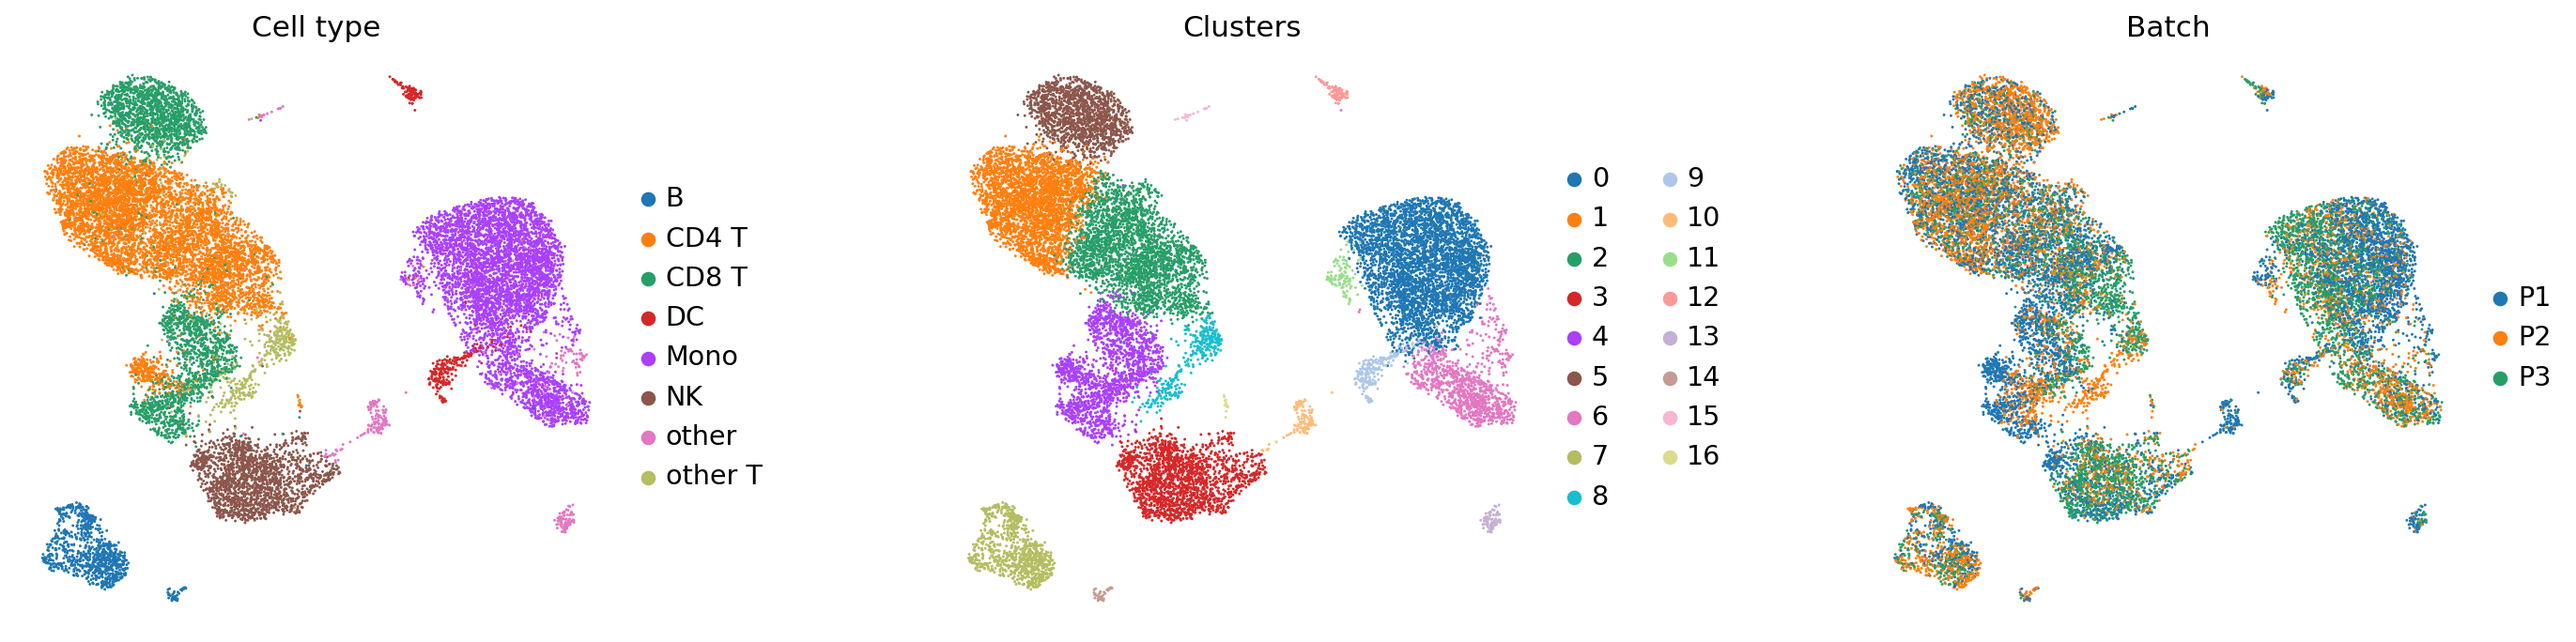

In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Теперь попробуем поменять: количество слоев (n_layers), распределение (gene_likelihood) и изменим параметры дисперсии (dispersion).

In [10]:
#изменение gene_likelihood на nb
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata, gene_likelihood='nb')

In [11]:
model.train(max_epochs=100)
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [08:14<00:00,  4.85s/it, loss=407, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [08:14<00:00,  4.95s/it, loss=407, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


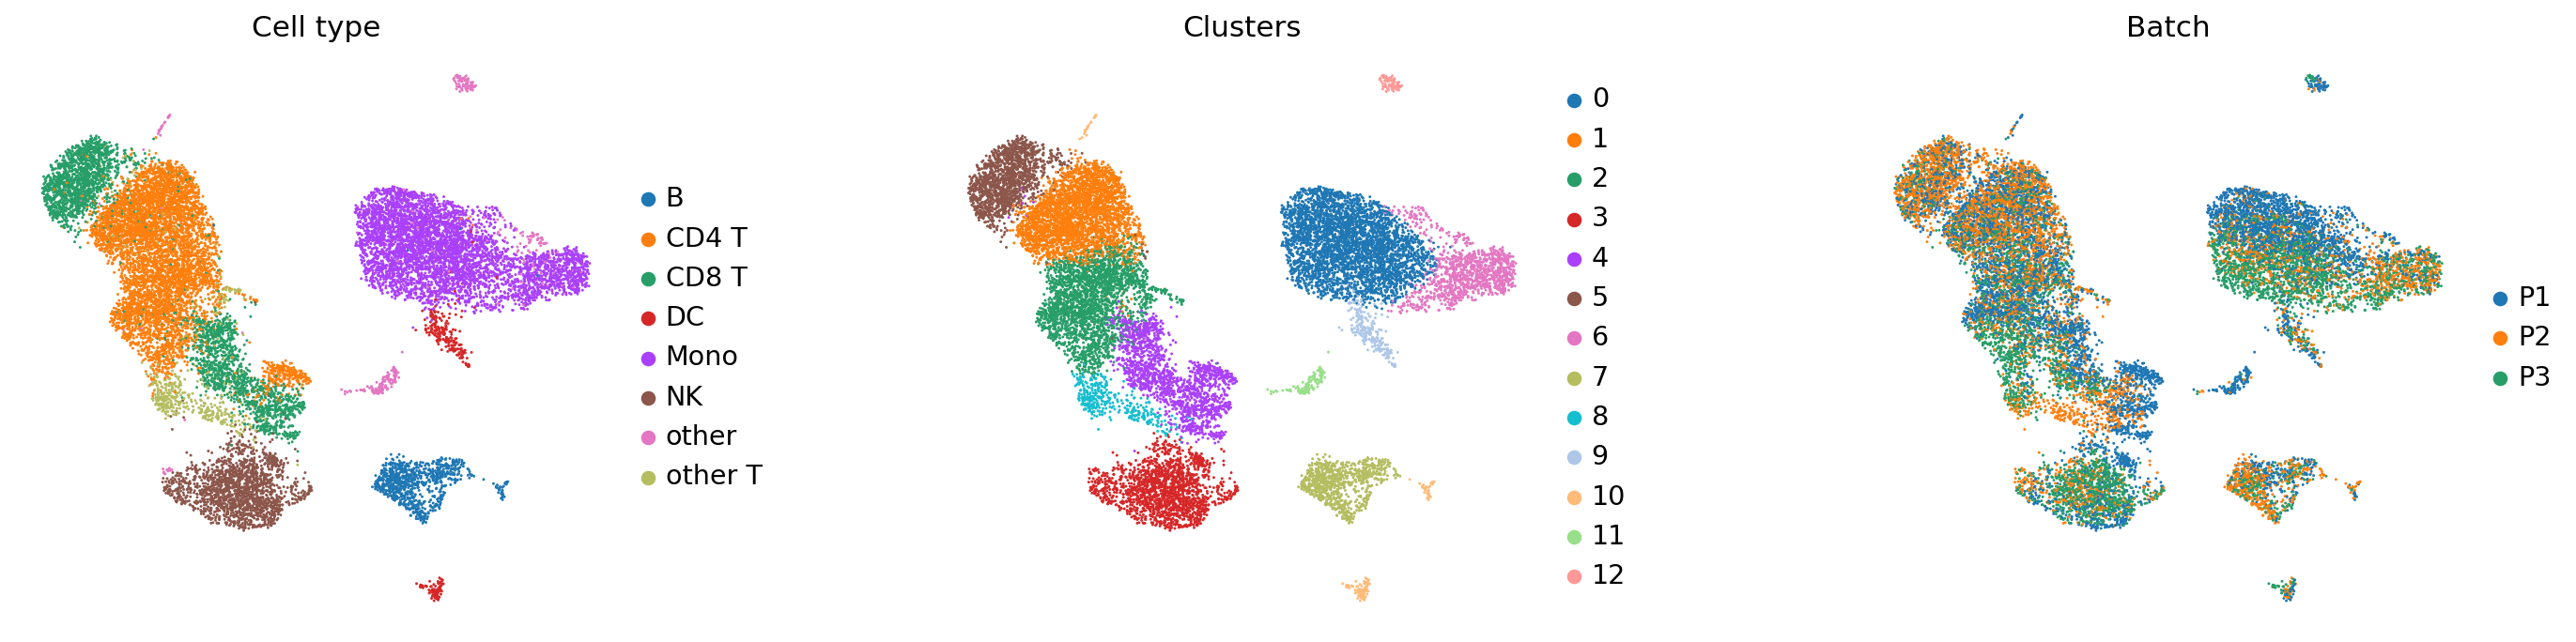

In [12]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

В целом кластеры сохранились. Немного изменили положение в пространстве, но для UMAP это нормальное явление.

In [13]:
#изменение n_layers
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata, n_layers=20)

In [14]:
model.train(max_epochs=100)
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [19:14<00:00, 11.04s/it, loss=458, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [19:14<00:00, 11.54s/it, loss=458, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


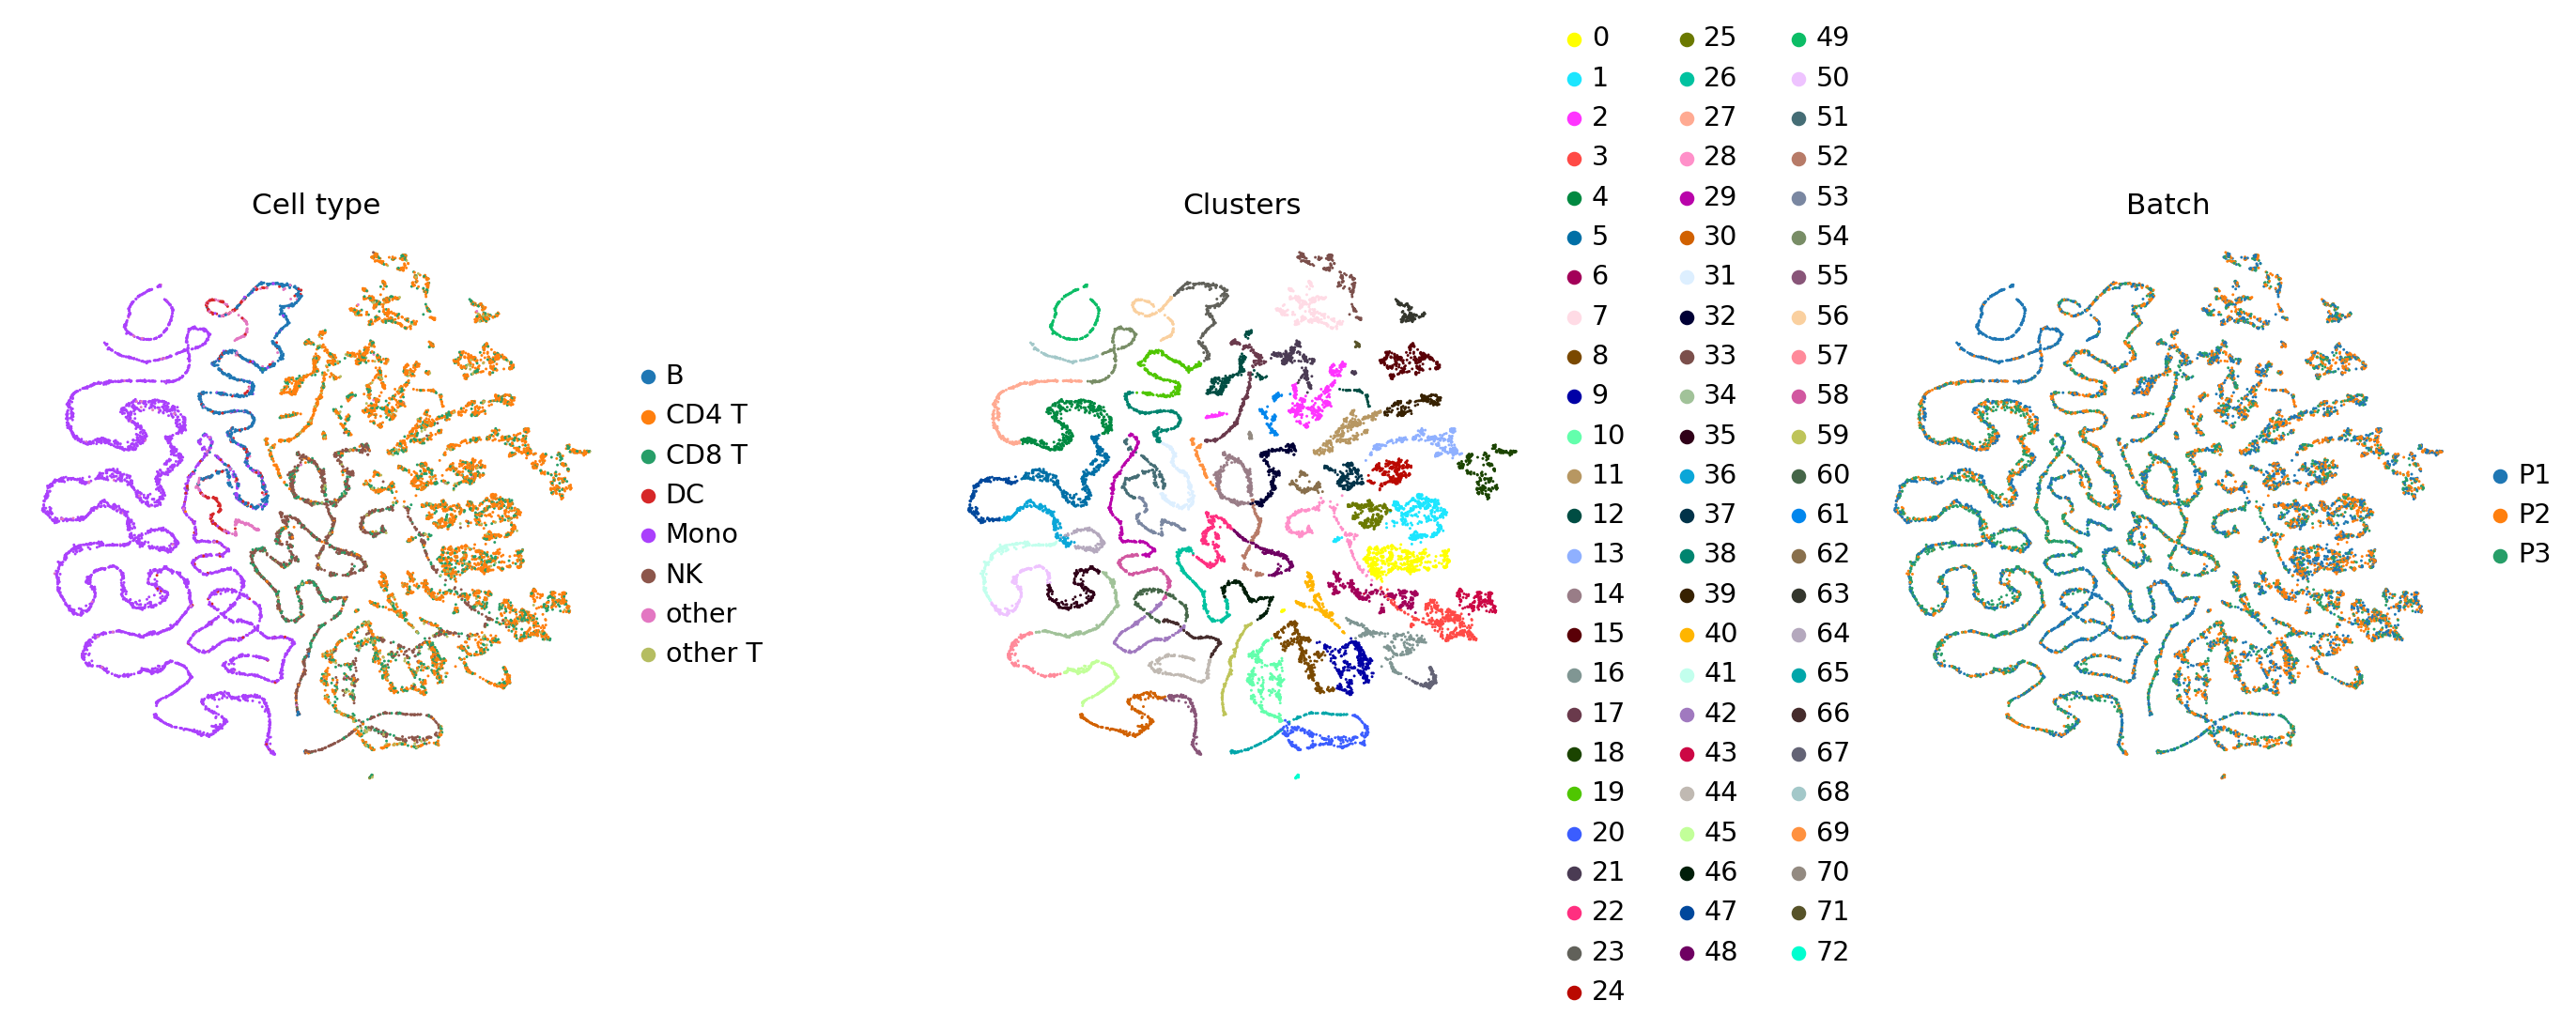

In [15]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

При большом количестве слоев явно произошло переобучение.

In [16]:
#поставим dispersion как 'gene-batch' - dispersion can differ between different batches
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata, dispersion="gene-batch")

In [17]:
model.train(max_epochs=100)
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [11:10<00:00,  6.16s/it, loss=401, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [11:10<00:00,  6.70s/it, loss=401, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


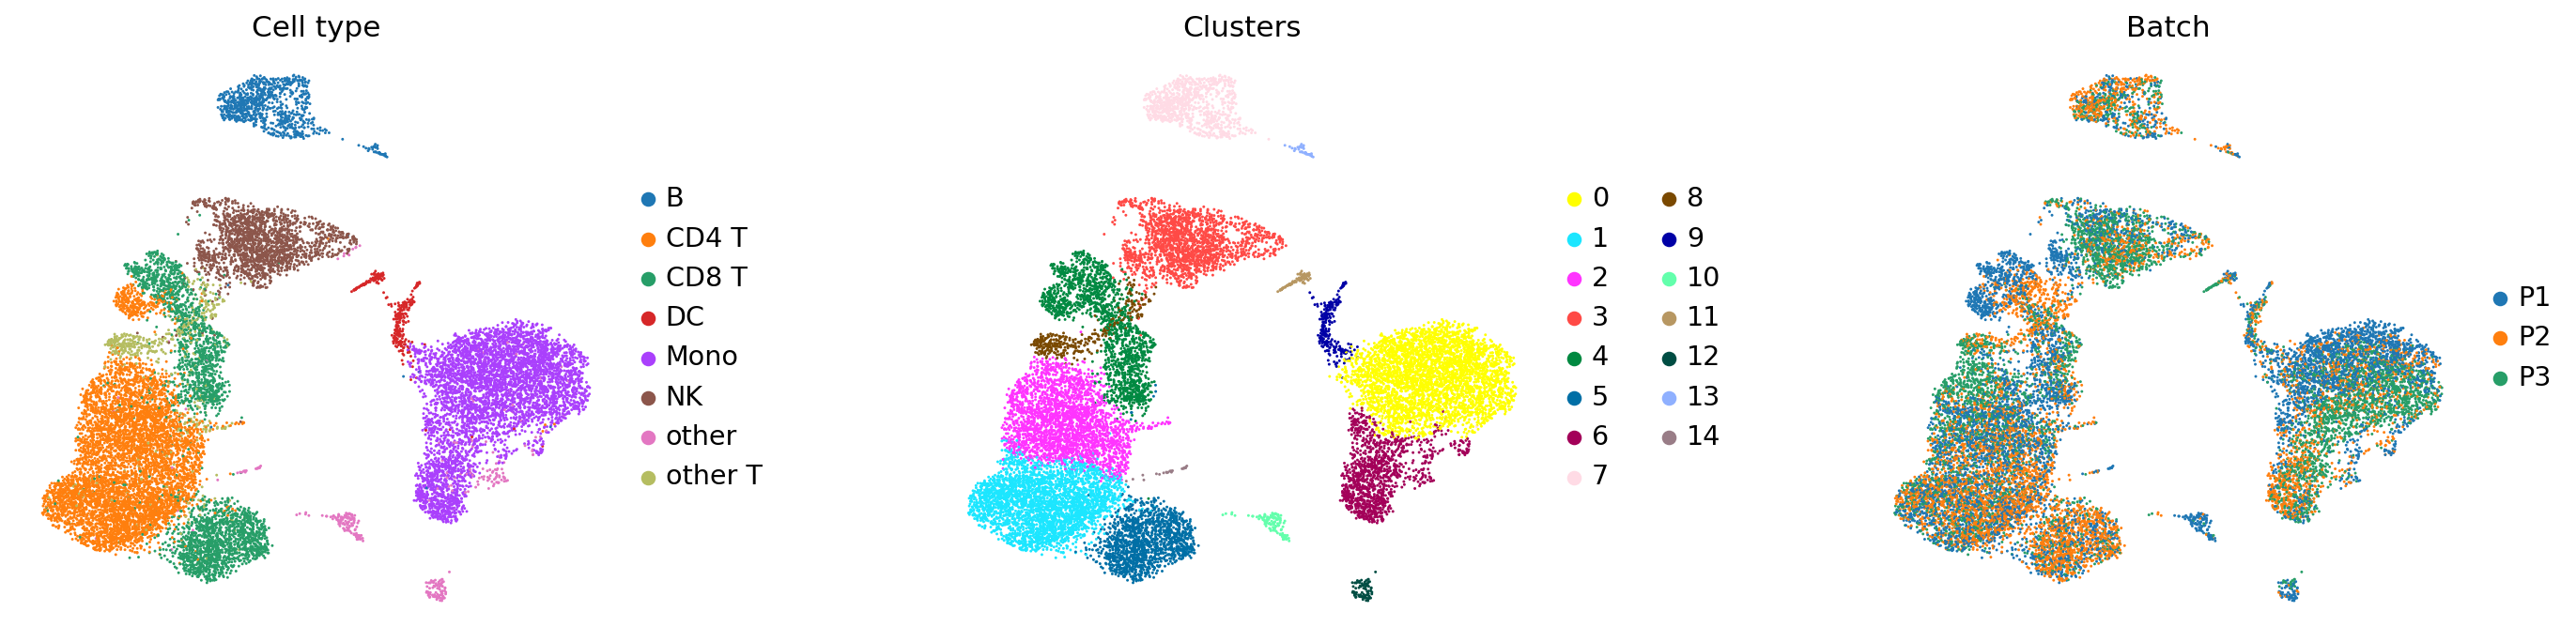

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


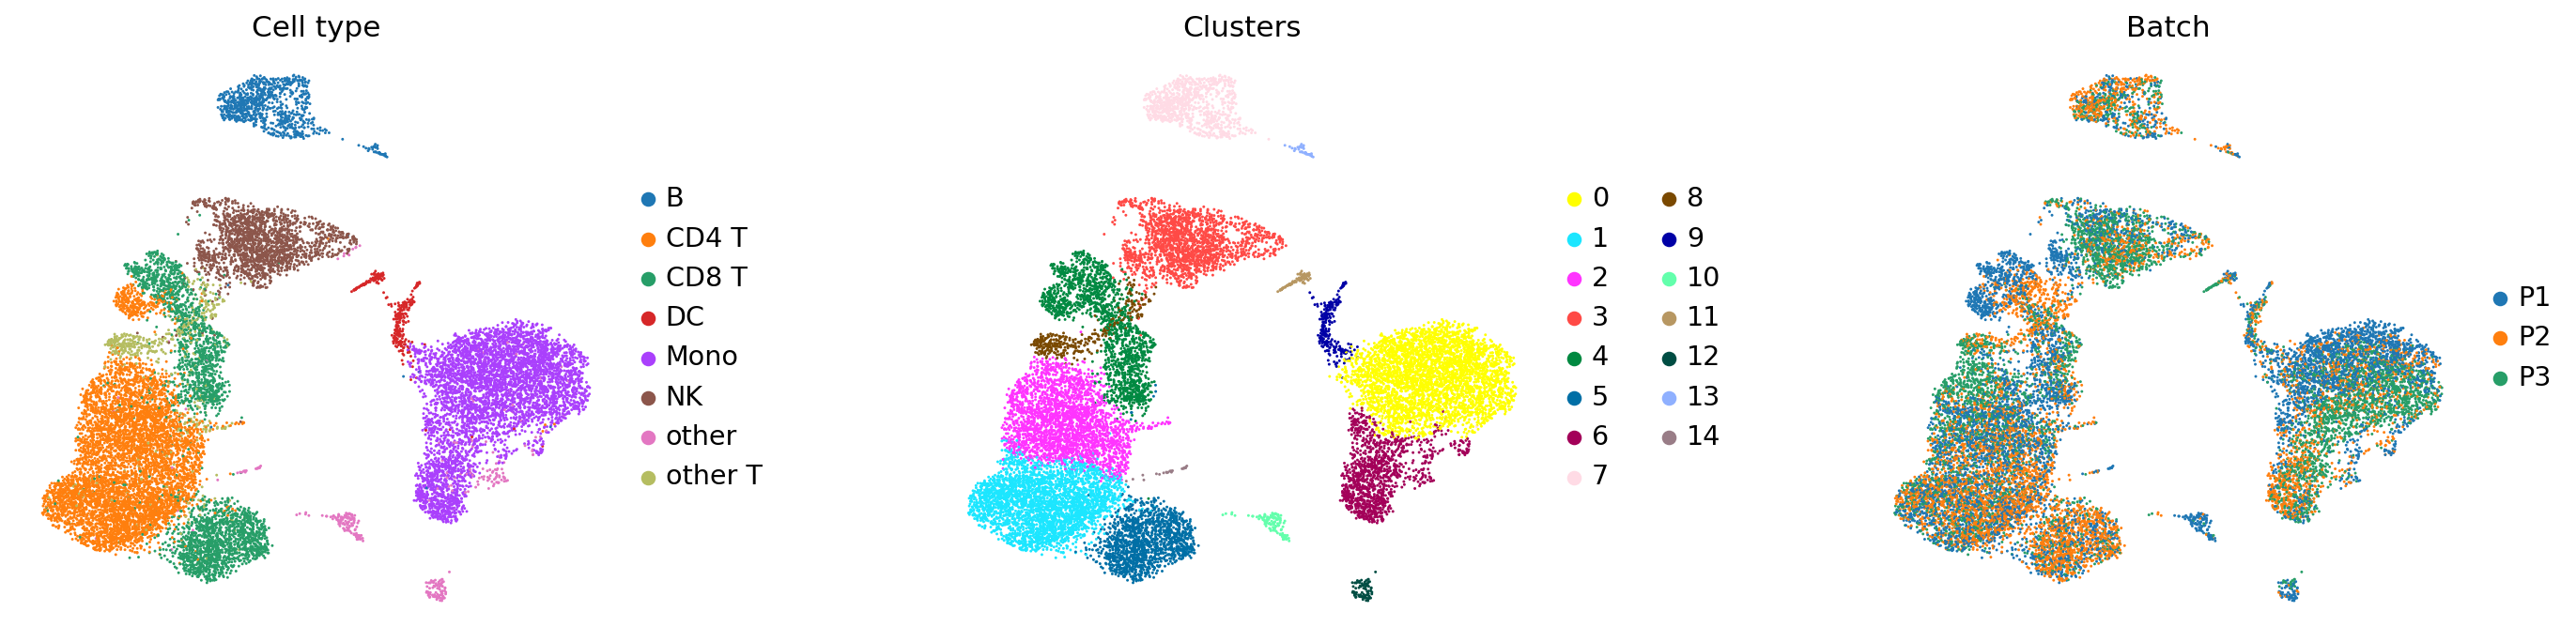

In [19]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

В принципе опять вышел такой же результат с точностью до расположения кластеров.